# Install Dependencies

In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ace_tools as tools
from sklearn.metrics.cluster import pair_confusion_matrix
from collections import Counter

ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Exploration

### Checking if Cho is a proper subset of KEGG

In [2]:
cho_data = pd.read_csv('../dataset/sourced/cho_ventures_cleaned.txt', sep='\t')
cho_genes = cho_data.iloc[:, 0]

kegg_data = pd.read_csv('../dataset/sourced/kegg_ventures_cleaned.txt', sep='\t')
kegg_genes = kegg_data.iloc[:, 0]

cho_genes_in_kegg = cho_genes.isin(kegg_genes)
cho_genes_not_in_kegg = cho_genes[~cho_genes_in_kegg]
missing_genes_count = cho_genes_not_in_kegg.count()
print("Are all cho_genes present in kegg_genes?", cho_genes_in_kegg.all())
print("Number of missing genes in kegg_genes:", missing_genes_count)
print(cho_genes_not_in_kegg)

Are all cho_genes present in kegg_genes? False
Number of missing genes in kegg_genes: 21
18     YLR273c
34     YKL042w
39     YNL225c
43     YLR313c
44     YGR041w
61     YJL173c
80     YMR179w
85     YDL227c
86     YNL173c
101    YMR198w
103    YDR356w
111    YDL197c
123    YIR017c
130    YKL049c
131    YCL014w
132    YOR188w
140    YLR014c
150    YBR138c
154    YJR092w
155    YLR353w
168    YDL048c
Name: Gene, dtype: object


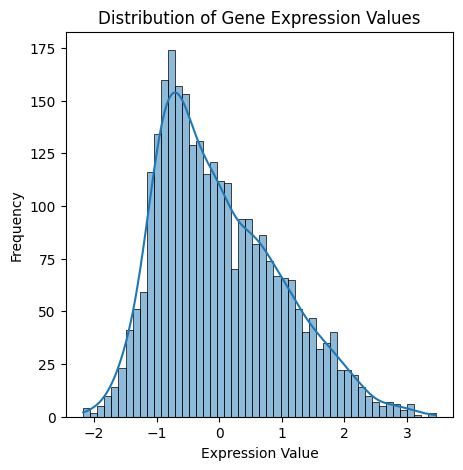

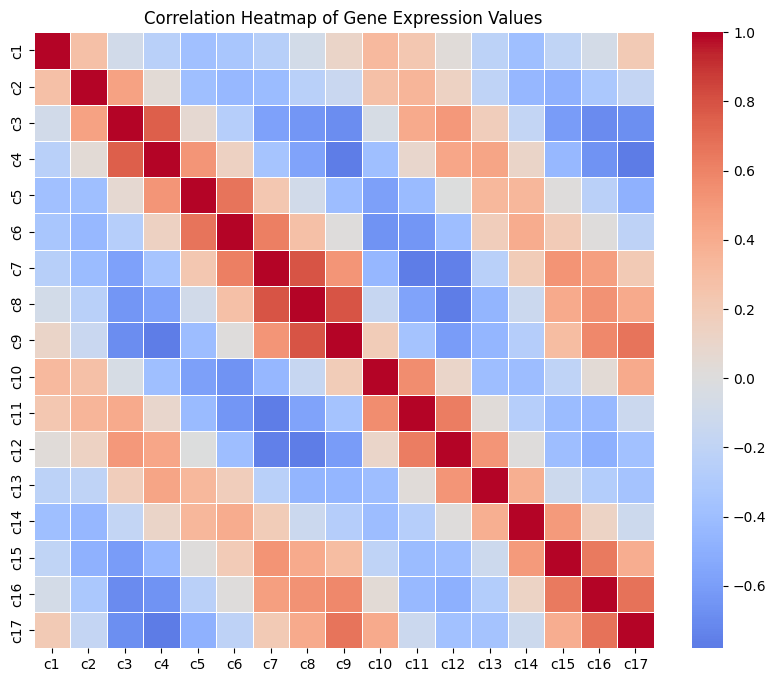

In [17]:

# Display basic dataset info
cho_data_info = cho_data.describe()

# Check the distribution of Level_1 and Level_2 categories
level1_counts = cho_data['Level_1'].value_counts()
level2_counts = cho_data['Level_2'].value_counts()

# Compute correlation matrix for expression values (excluding categorical columns)
expression_values = cho_data.iloc[:, 3:]
correlation_matrix = expression_values.corr()
# Plot histograms of expression values
plt.figure(figsize=(5, 5))
sns.histplot(expression_values.values.flatten(), bins=50, kde=True)
plt.title("Distribution of Gene Expression Values")
plt.xlabel("Expression Value")
plt.ylabel("Frequency")
plt.savefig('Data Graphs/cho_data_distribution.png')
plt.show()
plt.close()
# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap of Gene Expression Values")
plt.show()

# Formulation of the Modified Rand Index

In [77]:
def modified_rand_score(labels_true, labels_pred):
    """
    Computes the Modified Rand Index (MRI), an extension of the Rand Index
    that accounts for missing elements between partitions.
    
    Parameters:
    - labels_true: array-like, shape (n_samples,)
      Ground truth labels (e.g., KEGG or Cho dataset).
      
    - labels_pred: array-like, shape (n_samples,)
      Predicted labels from a clustering algorithm.

    Returns:
    - MRI: float
      A similarity score between 0.0 and 1.0, where higher values indicate better alignment.
    """
    
    # Compute confusion matrix components
    contingency = pair_confusion_matrix(labels_true, labels_pred)
    
    # Extract agreement and disagreement values
    n_00, n_01, n_10, n_11 = contingency.ravel()
    
    # Compute n_xx (pairs where at least one node is missing in one partition)
    total_nodes_true = len(set(labels_true))  # Unique classes in true labels
    total_nodes_pred = len(set(labels_pred))  # Unique classes in predicted labels
    missing_pairs = abs(total_nodes_true - total_nodes_pred) * (abs(total_nodes_true - total_nodes_pred) - 1) / 2
    n_xx = int(missing_pairs)

    # Compute total pairs
    total_pairs = n_00 + n_11 + n_01 + n_10 + n_xx

    # Compute MRI score
    if total_pairs == 0:
        return 1.0  # Perfect match in trivial cases

    MRI = (n_00 + n_11 + n_xx) / total_pairs
    return MRI

# Comparing KEGG and Cho (RI, ARI, MRI)

## Importing the necessary metrics from sklearn

In [78]:
from sklearn.metrics.cluster import rand_score, adjusted_rand_score

## Forming the KEGG groupings

In [79]:
# Create dictionary for storing KEGG definitions
kegg_definitions_csv = pd.read_csv("../classifications/atienza_maximo/kegg_definitions.csv", dtype={'Classification ID': str})

kegg_definitions_dict = kegg_definitions_csv.set_index('Classification ID').to_dict()['Function']

kegg_definitions_dict

{'09140': 'Cellular Processes',
 '09143': 'Cell growth and death',
 '04111': 'Cell cycle - yeast',
 '09130': 'Environmental Information Processing',
 '09132': 'Signal transduction',
 '04011': 'MAPK signaling pathway - yeast',
 '04113': 'Meiosis - yeast',
 '09180': 'Brite Hierarchies',
 '09182': 'Protein families: genetic information processing',
 '03000': 'Transcription factors [BR:sce03000]',
 '03032': 'DNA replication proteins [BR:sce03032]',
 '09120': 'Genetic Information Processing',
 '09124': 'Replication and repair',
 '03030': 'DNA replication',
 '03036': 'Chromosome and associated proteins [BR:sce03036]',
 '09181': 'Protein families: metabolism',
 '01009': 'Protein phosphatases and associated proteins [BR:sce01009]',
 '03019': 'Messenger RNA biogenesis [BR:sce03019]',
 '09183': 'Protein families: signaling and cellular processes',
 '04031': 'GTP-binding proteins [BR:sce04031]',
 '09100': 'Metabolism',
 '09101': 'Carbohydrate metabolism',
 '00020': 'Citrate cycle (TCA cycle)',
 '

In [80]:
# Read the Excel file
mdf = pd.read_excel('../classifications/ventures_calderon/for_groupings.xlsx', skiprows=0)

# Extract IDs
grouping = []
for gene, item in zip(mdf.iloc[:, 0].tolist(), mdf.iloc[:, 2].tolist()):
    IDs = re.findall(r'\b(\d{5}|\b(?![a-zA-Z]{7})\w{7}\b)\b', item)
    grouping.append({'Gene': gene, 'Grouping': IDs})

# Process grouping to remove entries following the first occurrence of a 7-character ID
for entry in grouping:
    IDs = entry['Grouping']
    for i, ID in enumerate(IDs):
        if len(ID) == 7:
            entry['Grouping'] = IDs[:i]  # Keep only IDs up to the first 7-character ID
            break

# Remove rows with empty
grouping = [entry for entry in grouping if entry['Grouping']]

# Create DataFrame from list of dictionaries
df_grouping_kegg = pd.DataFrame(grouping)

# Adding columns for each level of the IDs
max_levels = max(len(ids) for ids in df_grouping_kegg['Grouping'])
for i in range(max_levels):
    level_column_name = f'Level_{i+1}'
    level_description_column_name = f'Level_{i+1} Function'
    df_grouping_kegg[level_column_name] = df_grouping_kegg['Grouping'].apply(lambda x: x[:i+1] if len(x) > i else None)

# Adding columns to describe the function of each level
for i in range(max_levels):
    level_description_column_name = f'Level_{i+1} Function'
    df_grouping_kegg[level_description_column_name] = df_grouping_kegg[f'Level_{i+1}'].apply(lambda x: kegg_definitions_dict.get(x[-1], "Unknown") if isinstance(x, list) and x else "Unknown")

df_grouping_kegg.to_excel('output_grouping_kegg.xlsx', index=False)

print(df_grouping_kegg)
print(f"Number of genes after filtering: {len(grouping)}")
print(f"Number of unique groupings in Level 1: {len(df_grouping_kegg['Level_1'].value_counts())}")
print(f"Number of unique groupings in Level 2: {len(df_grouping_kegg['Level_2'].value_counts())}")
print(f"Number of unique groupings in Level 3: {len(df_grouping_kegg['Level_3'].value_counts())}")

        Gene               Grouping  Level_1         Level_2  \
0    YDL179w  [09140, 09143, 04111]  [09140]  [09140, 09143]   
1    YLR079w  [09130, 09132, 04011]  [09130]  [09130, 09132]   
2    YER111c  [09130, 09132, 04011]  [09130]  [09130, 09132]   
3    YBR200w  [09130, 09132, 04011]  [09130]  [09130, 09132]   
4    YJL194w  [09140, 09143, 04111]  [09140]  [09140, 09143]   
..       ...                    ...      ...             ...   
144  YNL053w  [09130, 09132, 04011]  [09130]  [09130, 09132]   
145  YKL130C  [09180, 09182, 03019]  [09180]  [09180, 09182]   
146  YIL162w  [09100, 09101, 00052]  [09100]  [09100, 09101]   
147  YDL138W  [09140, 09143, 04113]  [09140]  [09140, 09143]   
148  YGR143w  [09180, 09182, 04131]  [09180]  [09180, 09182]   

                   Level_3                      Level_1 Function  \
0    [09140, 09143, 04111]                    Cellular Processes   
1    [09130, 09132, 04011]  Environmental Information Processing   
2    [09130, 09132, 04011] 

In [81]:
# Create dictionary
gene_grouping_kegg = {gene: grouping for gene, grouping in zip(df_grouping_kegg['Gene'], df_grouping_kegg['Grouping'])}

print(gene_grouping_kegg)
print(len(gene_grouping_kegg))

{'YDL179w': ['09140', '09143', '04111'], 'YLR079w': ['09130', '09132', '04011'], 'YER111c': ['09130', '09132', '04011'], 'YBR200w': ['09130', '09132', '04011'], 'YJL194w': ['09140', '09143', '04111'], 'YLR274w': ['09120', '09124', '03030'], 'YBR202w': ['09120', '09124', '03030'], 'YPR019w': ['09120', '09124', '03030'], 'YBL023c': ['09120', '09124', '03030'], 'YEL032w': ['09120', '09124', '03030'], 'YJL157c': ['09130', '09132', '04011'], 'YKL185w': ['09180', '09182', '03000'], 'YHR005c': ['09130', '09132', '04011'], 'YLR395c': ['09100', '09102', '00190'], 'YDL181w': ['09180', '09182', '04131'], 'YGR183c': ['09100', '09102', '00190'], 'YLR258w': ['09100', '09101', '00500'], 'YML110c': ['09100', '09108', '00130'], 'YCR005c': ['09100', '09101', '00020'], 'YCL040w': ['09100', '09101', '00010'], 'YMR256c': ['09100', '09102', '00190'], 'YIL009w': ['09100', '09103', '00061'], 'YLL040c': ['09180', '09182', '04131'], 'YNR016c': ['09100', '09101', '00620'], 'YGR109c': ['09130', '09132', '04011'],

## Forming the Cho groupings

In [82]:
# Read the Excel file
mdf = pd.read_excel('../classifications/ventures_calderon/for_groupings.xlsx')

# Extract Gene, Level_1, and Level_2 columns
df_grouping_cho = mdf.iloc[:, [0, 5, 6]].copy()  # Create a copy to avoid modifying the original DataFrame

# Rename the columns
df_grouping_cho.columns = ['Gene', 'Level_1', 'Level_2']

# Treat Level_1 and Level_2 columns as strings
df_grouping_cho['Level_1'] = df_grouping_cho['Level_1'].astype(str)
df_grouping_cho['Level_2'] = df_grouping_cho['Level_2'].astype(str)

# Merge Level_1 and Level_2 columns into a single Grouping column
df_grouping_cho['Grouping'] = df_grouping_cho[['Level_1', 'Level_2']].apply(list, axis=1)

# Filter out rows with similar elements in the groupings: no subcluster if similar
def has_duplicate_elements(grouping):
    element_counts = Counter(grouping)
    return any(count > 1 for count in element_counts.values())

df_grouping_cho = df_grouping_cho[~df_grouping_cho['Grouping'].apply(has_duplicate_elements)]

# Reorder columns
df_grouping_cho = df_grouping_cho[['Gene', 'Grouping', 'Level_1', 'Level_2']]

df_grouping_cho.reset_index(drop=True, inplace=True)

df_grouping_kegg.to_excel('output_grouping_cho.xlsx', index=False)

print(df_grouping_cho)
print(f"Number of genes after filtering: {len(df_grouping_cho)}")
print(f"Number of unique groupings in Level 1: {len(df_grouping_cho['Level_1'].value_counts())}")
print(f"Number of unique groupings in Level 2: {len(df_grouping_cho['Level_2'].value_counts())}")

        Gene Grouping Level_1 Level_2
0    YDL179w  [1, 11]       1      11
1    YLR079w  [1, 11]       1      11
2    YER111c  [1, 11]       1      11
3    YBR200w  [1, 12]       1      12
4    YJL194w  [1, 13]       1      13
..       ...      ...     ...     ...
144  YNL053w  [5, 57]       5      57
145  YKL130C  [5, 57]       5      57
146  YIL162w  [5, 58]       5      58
147  YDL138W  [5, 58]       5      58
148  YGR143w  [5, 59]       5      59

[149 rows x 4 columns]
Number of genes after filtering: 149
Number of unique groupings in Level 1: 5
Number of unique groupings in Level 2: 37


In [83]:
# Create dictionary
gene_grouping_cho = {gene: grouping for gene, grouping in zip(df_grouping_cho['Gene'], df_grouping_cho['Grouping'])}

print(gene_grouping_cho)
print(len(gene_grouping_cho))

{'YDL179w': ['1', '11'], 'YLR079w': ['1', '11'], 'YER111c': ['1', '11'], 'YBR200w': ['1', '12'], 'YJL194w': ['1', '13'], 'YLR274w': ['1', '13'], 'YBR202w': ['1', '13'], 'YPR019w': ['1', '13'], 'YBL023c': ['1', '13'], 'YEL032w': ['1', '13'], 'YJL157c': ['1', '14'], 'YKL185w': ['1', '14'], 'YHR005c': ['1', '14'], 'YLR395c': ['1', '15'], 'YDL181w': ['1', '15'], 'YGR183c': ['1', '15'], 'YLR258w': ['1', '15'], 'YML110c': ['1', '15'], 'YCR005c': ['1', '15'], 'YCL040w': ['1', '15'], 'YMR256c': ['1', '15'], 'YIL009w': ['1', '16'], 'YLL040c': ['1', '16'], 'YNR016c': ['1', '16'], 'YGR109c': ['2', '21'], 'YPR120c': ['2', '21'], 'YDL127w': ['2', '21'], 'YNL289w': ['2', '21'], 'YPL256c': ['2', '21'], 'YMR199w': ['2', '21'], 'YJL187c': ['2', '21'], 'YDL003w': ['2', '22'], 'YMR076c': ['2', '22'], 'YFL008w': ['2', '22'], 'YPL241c': ['2', '22'], 'YMR078c': ['2', '22'], 'YLR212c': ['2', '22'], 'YPL209c': ['2', '22'], 'YJL074c': ['2', '22'], 'YNL233w': ['2', '23'], 'YGR152c': ['2', '23'], 'YDR507c': ['2'

## RI, MRI, and ARI comparison

In [84]:
# Function to calculate the metric scores for different levels of groupings
def calculate_ari(kegg, cho, level_kegg, level_cho):
    kegg_labels = [value[level_kegg] for value in kegg.values()]
    cho_labels = [value[level_cho] for value in cho.values()]

    # print(kegg_labels)
    # print(cho_labels)

    ri = rand_score(kegg_labels, cho_labels)
    ari = adjusted_rand_score(kegg_labels, cho_labels)
    mri = modified_rand_score(kegg_labels, cho_labels)
    return ri, ari, mri

# List to store ARI values
ari_values = []

# Loop through different levels of KEGG and CHO groupings
for level_kegg in range(3):
    for level_cho in range(2):
        ri, ari, mri = calculate_ari(gene_grouping_kegg, gene_grouping_cho, level_kegg, level_cho)
        ari_values.append({'KEGG Level': level_kegg+1, 'CHO Level': level_cho+1, 'RI': ri, 'ARI': ari, 'MRI': mri})

# Create DataFrame to store ARI values
ari_df = pd.DataFrame(ari_values)

# Display DataFrame
print(ari_df)

   KEGG Level  CHO Level        RI       ARI       MRI
0           1          1  0.653909  0.022699  0.653909
1           1          2  0.787412  0.083272  0.791802
2           2          1  0.707237  0.057357  0.708625
3           2          2  0.866135  0.118445  0.866955
4           3          1  0.734264  0.043423  0.745195
5           3          2  0.922728  0.156492  0.922959
